In [1]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import LearningRateScheduler # Adaptive Lernrate: Passt jede Epoche die Lernrate an
from tensorflow.keras.callbacks import ReduceLROnPlateau # Passt Lernrate an (factor), wenn Training stagniert (Min_delta)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Hat auch eine adaptive Lernrate

from tf_utils.dogscatsDataAdvanced import DOGSCATS
from tf_utils.callbacks import LRTensorBoard
from tf_utils.callbacks import schedule_fn
from tf_utils.callbacks import schedule_fn2
from tf_utils.callbacks import schedule_fn3
from tf_utils.callbacks import schedule_fn4

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
CUSTOM_IMAGES_DIR = os.path.abspath("C:/Selbststudium/Zubehoer/Cats_and_dogs/custom/")

In [4]:
MODELS_DIR = os.path.abspath('C:/Selbststudium/Udemy/Udemy_Tensorflow/models/')
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

In [5]:
MODEL_FILE_PATH = os.path.join(MODELS_DIR, "dogs_cats.h5")

In [6]:
LOGS_DIR = os.path.abspath('C:/Selbststudium/Udemy/Udemy_Tensorflow/logs/DOGSCATS/')
if not os.path.exists(LOGS_DIR):
    os.mkdir(LOGS_DIR)

In [7]:
def build_model(
    img_shape: Tuple[int, int, int],
    num_classes: int,
    optimizer: tf.keras.optimizers.Optimizer,
    learning_rate: float,
    filter_block_1: int,
    kernel_size_block_1: int,
    filter_block_2: int,
    kernel_size_block_2: int,
    filter_block_3: int,
    kernel_size_block_3: int,
    dense_layer_size: int,
    kernel_initializer: tf.keras.initializers.Initializer,
    activation_cls: tf.keras.layers.Activation,
    dropout_rate: float,
    use_batch_normalization: bool,
    use_dense: bool,
    use_global_pooling: bool
) -> Model:
    input_img = Input(shape=img_shape)

    x = Conv2D(
        filters=filter_block_1, 
        kernel_size=kernel_size_block_1, 
        padding='same', 
        kernel_initializer=kernel_initializer
    )(input_img)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    x = activation_cls(x)
    x = Conv2D(
        filters=filter_block_1, 
        kernel_size=kernel_size_block_1, 
        padding='same', 
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(rate=dropout_rate)(x)
    x = activation_cls(x)
    x = MaxPool2D()(x)

    x = Conv2D(
        filters=filter_block_2, 
        kernel_size=kernel_size_block_2, 
        padding='same', 
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    x = activation_cls(x)
    x = Conv2D(
        filters=filter_block_2, 
        kernel_size=kernel_size_block_2, 
        padding='same', 
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(rate=dropout_rate)(x)
    x = activation_cls(x)
    x = MaxPool2D()(x)

    x = Conv2D(
        filters=filter_block_3, 
        kernel_size=kernel_size_block_3, 
        padding='same', 
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    x = activation_cls(x)
    x = Conv2D(
        filters=filter_block_3, 
        kernel_size=kernel_size_block_3, 
        padding='same', 
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(rate=dropout_rate)(x)
    x = activation_cls(x)
    x = MaxPool2D()(x)

    if use_global_pooling:
        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)
    if use_dense:
        x = Dense(
            units=dense_layer_size, 
            kernel_initializer=kernel_initializer
        )(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = activation_cls(x)
    x = Dense(
        units=num_classes, 
        kernel_initializer=kernel_initializer
    )(x)
    y_pred = Activation('softmax')(x)

    # Jetzt muss noch ein Modell Objekt mit eben obiger Struktur erstellt werden
    model = Model(
        inputs = [input_img],
        outputs = [y_pred]
    )
    
    opt = optimizer(learning_rate=learning_rate)
    
    model.compile(
        loss='categorical_crossentropy', # wird bei Kategorie-Problemen mit mehr als 2 Klassen genommen
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

In [8]:
data = DOGSCATS()

train_dataset = data.get_train_set()
val_dataset = data.get_val_set()
test_dataset = data.get_test_set()

img_shape = data.img_shape
num_classes = data.num_classes

epochs = 100
batch_size = 128

# Best model params
params = {
    "optimizer": Adam,
    "learning_rate": 0.001,
    "filter_block_1": 32,
    "kernel_size_block_1": 3,
    "filter_block_2": 64,
    "kernel_size_block_2": 3,
    "filter_block_3": 128,
    "kernel_size_block_3": 3,
    "dense_layer_size": 128,
    "kernel_initializer": "GlorotUniform",
    "activation_cls": ReLU(),
    "dropout_rate": 0.0,
    "use_batch_normalization": True,
    "use_dense": True,
    "use_global_pooling": True
}

In [9]:
# In diesem Video bzw. genau diesem Abschnitt wird Batch Normalization getestet

model = build_model(
    img_shape,
    num_classes,
    **params
)

model_log_dir = os.path.join(LOGS_DIR, f"model_final")

lrs_callback = LearningRateScheduler(
    schedule=schedule_fn2,
    verbose=1
)

plateau_callback = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.99,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

lr_callback = LRTensorBoard(
    log_dir=model_log_dir,
    histogram_freq=0,
    profile_batch=0,
    write_graph=0
)

es_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=30,
    verbose=1,
    restore_best_weights=True,
    min_delta=0.0005
)

In [10]:
model.fit(
    train_dataset,
    verbose=1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[es_callback, lrs_callback, lr_callback],
    validation_data=val_dataset,
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
105/105 [==============================] - 14s 49ms/step - loss: 0.6420 - accuracy: 0.6461 - val_loss: 0.8930 - val_accuracy: 0.4973 - lr: 0.0010 - learning_rate: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
105/105 [==============================] - 4s 43ms/step - loss: 0.5444 - accuracy: 0.7244 - val_loss: 1.0157 - val_accuracy: 0.4974 - lr: 0.0010 - learning_rate: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
105/105 [==============================] - 4s 42ms/step - loss: 0.4619 - accuracy: 0.7823 - val_loss: 1.1903 - val_accuracy: 0.4982 - lr: 0.0010 - learning_rate: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
105/105 [==============================] - 4s 42ms/step - loss: 0.4043 - accuracy: 0.8157 - val_loss: 1.3110 - val_accuracy: 0.5109 - lr: 0.0010 - learning_rate: 0.0010

Ep

In [11]:
model.save_weights(MODEL_FILE_PATH)

In [12]:
model.load_weights(MODEL_FILE_PATH)

In [13]:
image_names = [f for f in os.listdir(CUSTOM_IMAGES_DIR) if ".jpg" in f or ".jpeg" in f or ".png" in f]
class_names = ["cat", "dog"]

[8.9071700e-06 9.9999106e-01]
1


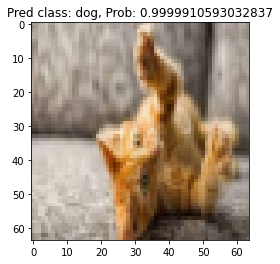

[0.45166427 0.54833573]
1


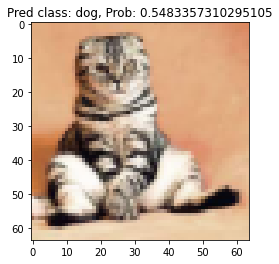

[9.9979728e-01 2.0271656e-04]
0


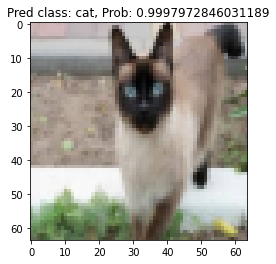

[6.938897e-07 9.999993e-01]
1


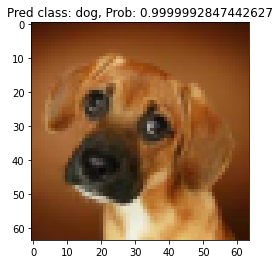

[2.0336688e-10 1.0000000e+00]
1


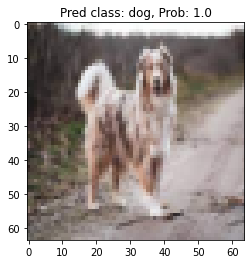

[8.3910146e-07 9.9999917e-01]
1


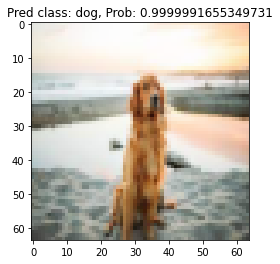

In [14]:
for image_file_name in image_names:
        image_file_path = os.path.join(CUSTOM_IMAGES_DIR, image_file_name)
        x = data.load_and_preprocess_custom_image(image_file_path)
        x = np.expand_dims(x, axis=0) # Batch Dimension
        y_pred = model.predict(x)[0] # One Hot Vector
        print(y_pred)
        y_pred_class_idx = np.argmax(y_pred)
        y_pred_prob = y_pred[y_pred_class_idx]
        print(y_pred_class_idx)
        y_pred_class_name = class_names[y_pred_class_idx]
        plt.imshow(x.reshape(64, 64, 3))
        plt.title(f"Pred class: {y_pred_class_name}, Prob: {y_pred_prob}")
        plt.show()